In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

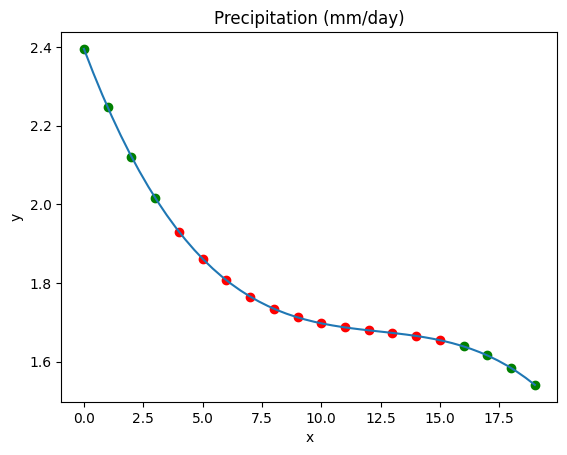

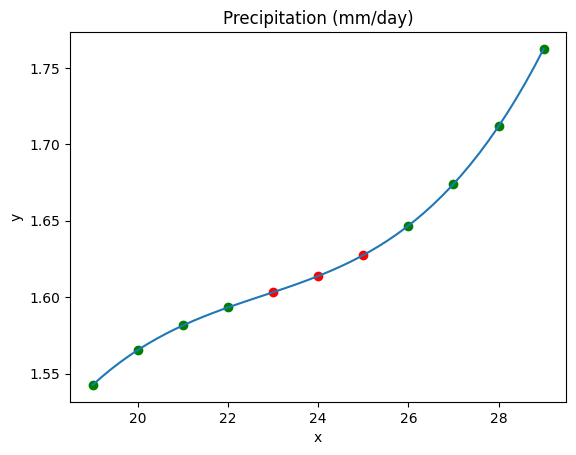

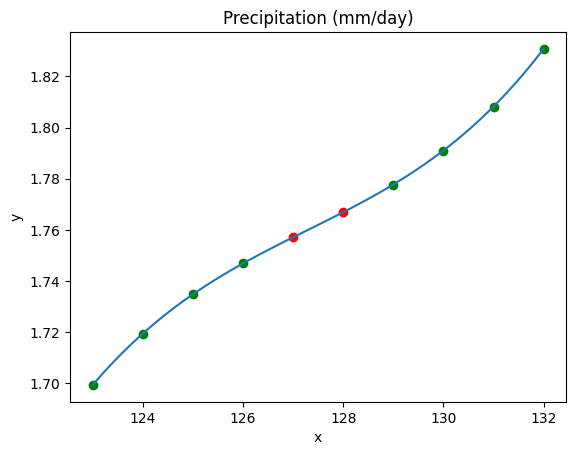

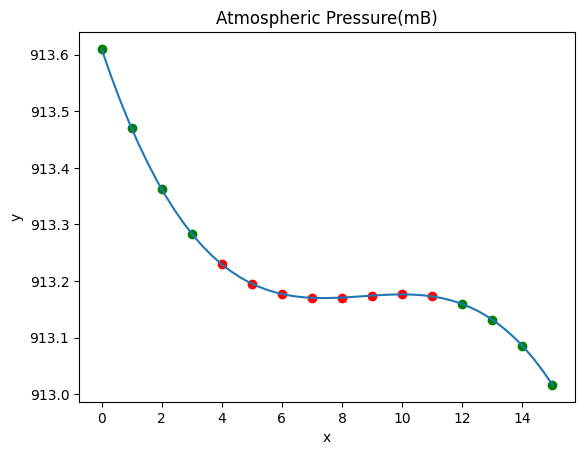

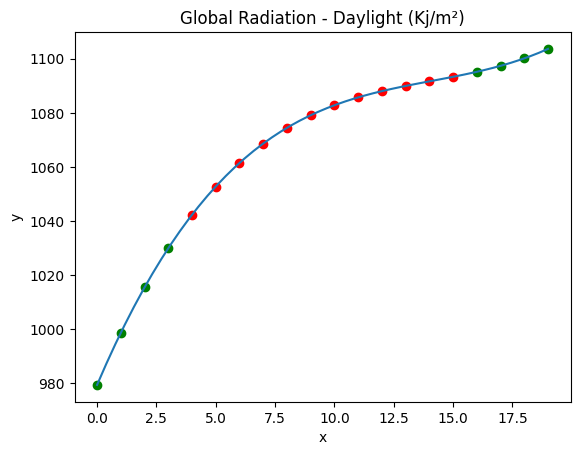

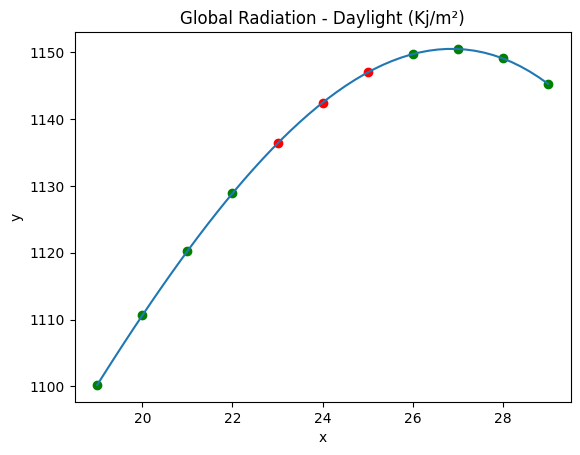

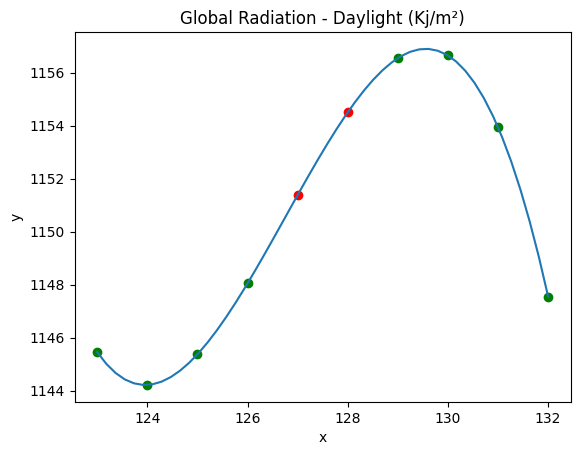

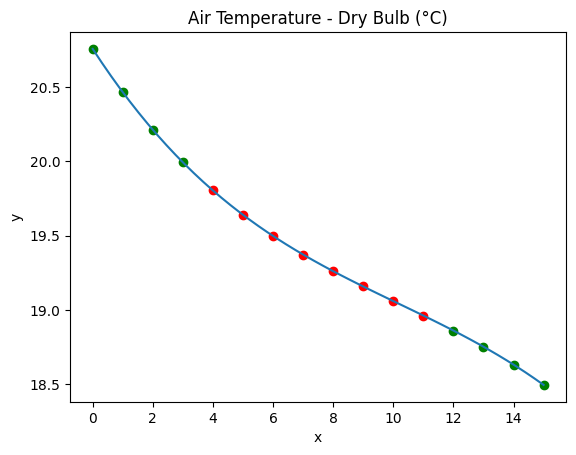

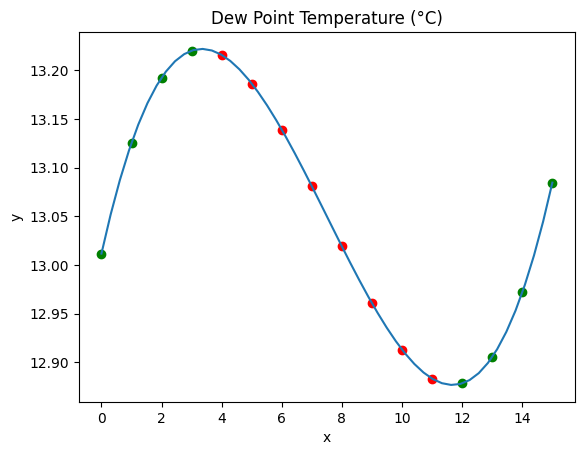

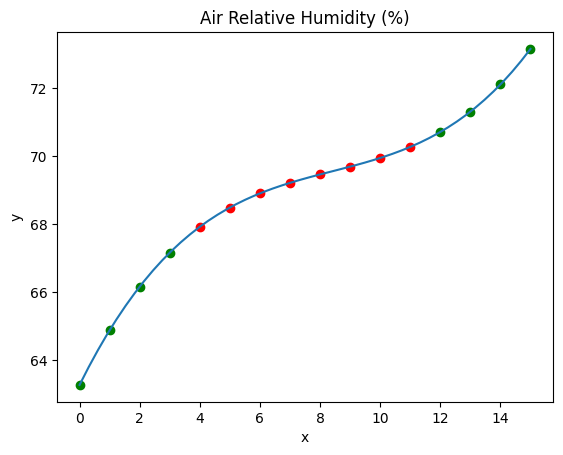

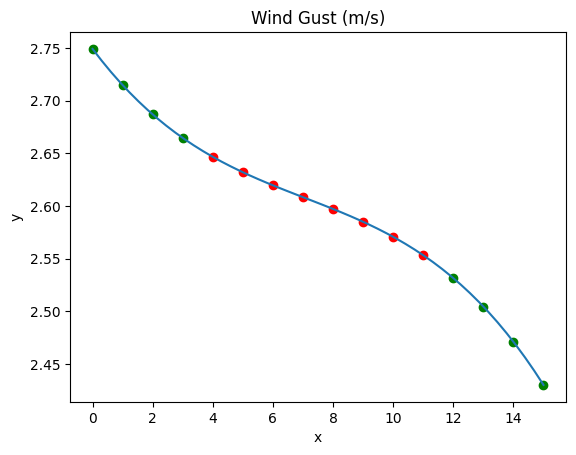

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2004,2.356613,913.609701,984.387464,20.714076,13.000763,63.418248,2.734421
1,2004,2.296103,913.476368,993.264068,20.508520,13.117430,64.640471,2.734421
2,2004,2.161831,913.359411,1008.410883,20.286298,13.245105,66.057887,2.702375
3,2004,1.962251,913.277973,1037.766768,19.915505,13.186857,67.366561,2.643052
4,2004,1.930711,913.229547,1042.299355,19.804018,13.215629,67.918569,2.646739
...,...,...,...,...,...,...,...,...
223,2022,1.782379,912.861346,1141.501301,17.611833,13.343353,70.789821,1.830405
224,2022,1.799174,912.766553,1145.276163,17.713442,13.417079,70.826536,1.832693
225,2022,1.823062,912.708988,1152.583512,17.838049,13.506316,70.432033,1.820768
226,2022,1.834915,912.735266,1153.497873,17.837613,13.477670,70.034388,1.811751


In [7]:
df = read_csv_replace_missing_by_polynomial('parana_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [8]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2004,22.972811,913.265877,1047.582355,19.681640,13.078961,67.946005,2.635633
2005,19.394669,913.070816,1104.430377,18.349801,12.918562,73.045195,2.472367
2006,20.838443,912.939217,1154.697938,18.215722,13.137363,74.760361,2.419027
2007,21.243438,912.795925,1190.491946,17.985412,13.233020,76.217173,2.335890
2008,17.558665,912.624708,1226.296848,18.012164,13.653739,78.027482,2.236583
2009,16.652522,912.466179,1217.653383,17.954863,13.668549,78.238643,2.155189
2010,17.928528,912.482023,1194.060192,17.703414,13.001948,76.311573,2.092804
2011,18.661309,912.629463,1182.416452,17.710041,12.630186,74.615878,2.043995
2012,19.310061,912.778766,1176.491125,17.874291,12.612094,73.865245,1.941425


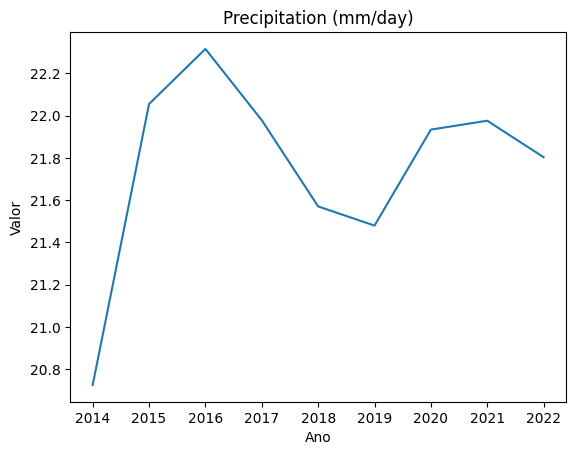

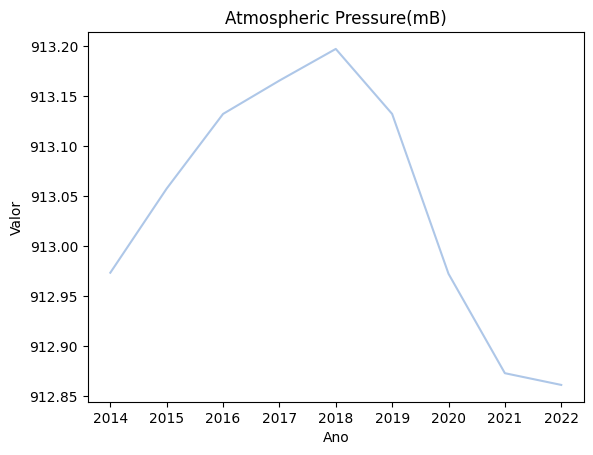

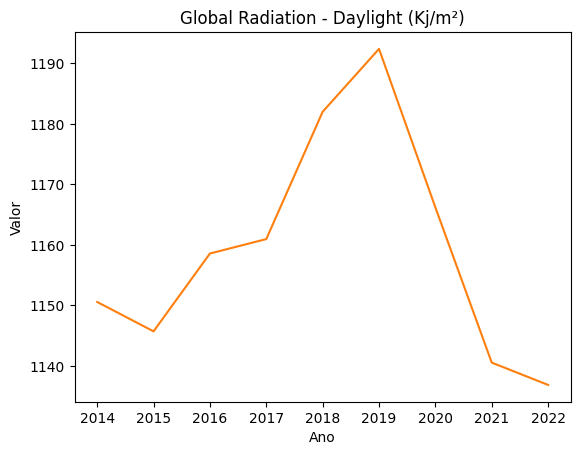

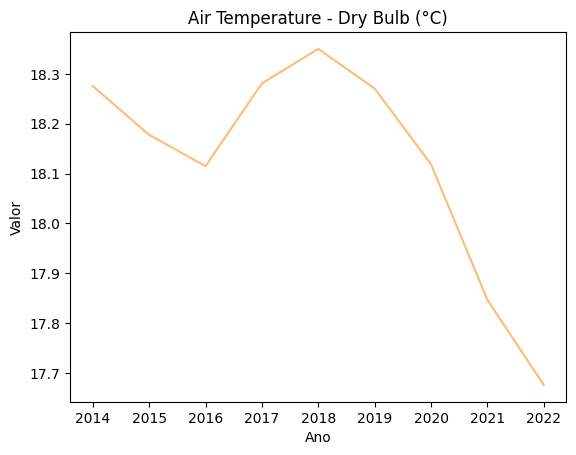

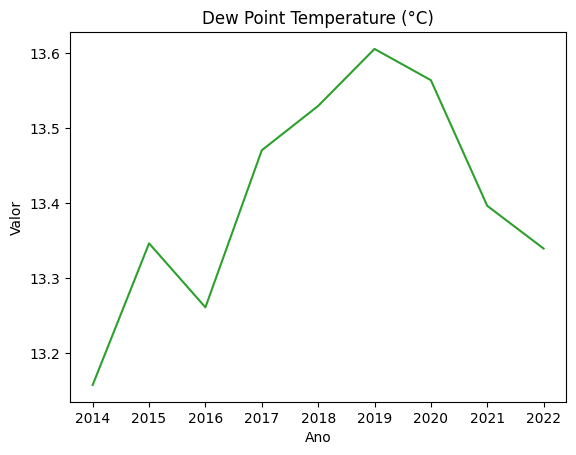

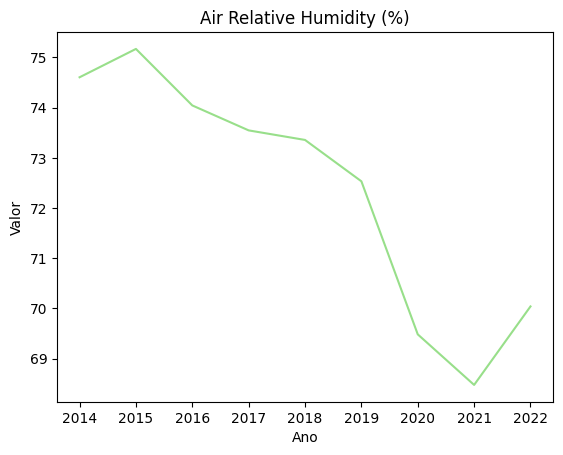

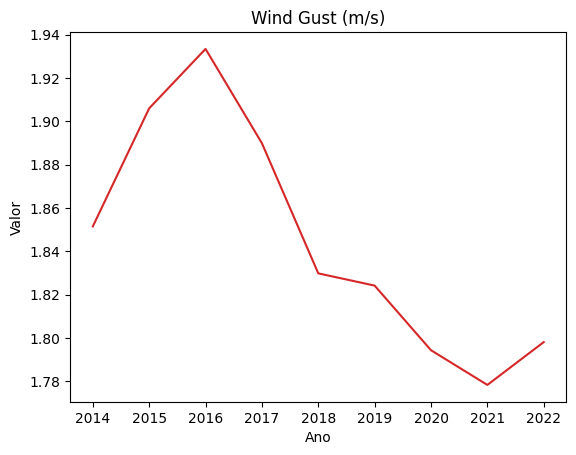

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,20.725057,912.973266,1150.562966,18.275455,13.157699,74.605015,1.851460
2015,22.054778,913.057535,1145.712487,18.177724,13.346348,75.170150,1.905966
2016,22.315526,913.132268,1158.573328,18.115048,13.261122,74.043778,1.933375
2017,21.977949,913.165670,1160.957791,18.281050,13.470416,73.546507,1.889856
2018,21.569960,913.197376,1181.996564,18.350169,13.529500,73.356104,1.829790
2019,21.479228,913.132269,1192.379390,18.270645,13.605491,72.531518,1.824138
2020,21.933567,912.972214,1166.191854,18.118751,13.563808,69.481534,1.794314
2021,21.975729,912.872647,1140.544113,17.846885,13.396376,68.473686,1.778305
2022,21.803048,912.860902,1136.860026,17.676137,13.339456,70.038046,1.798074


In [9]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

In [10]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

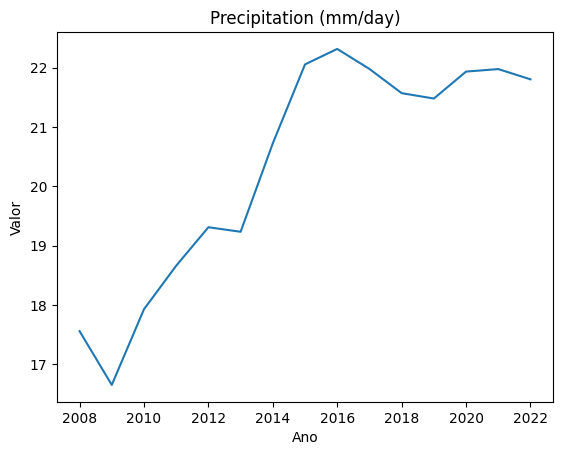

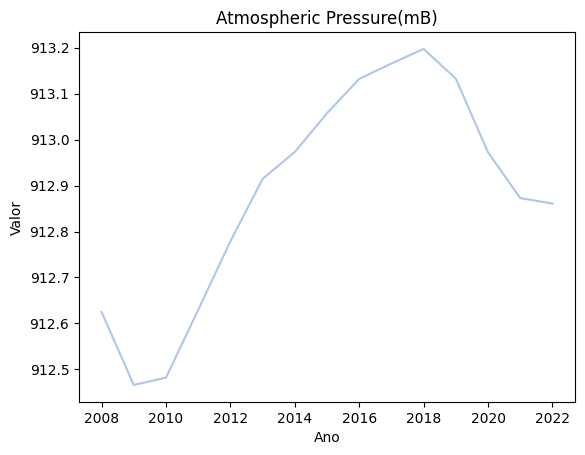

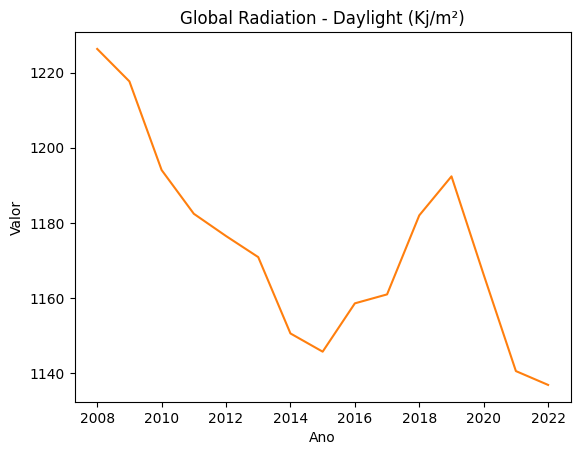

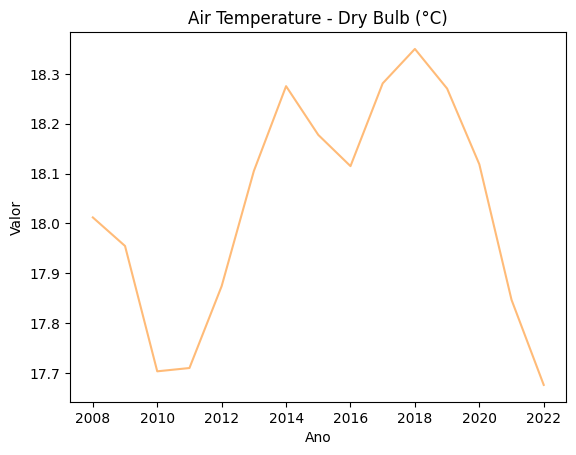

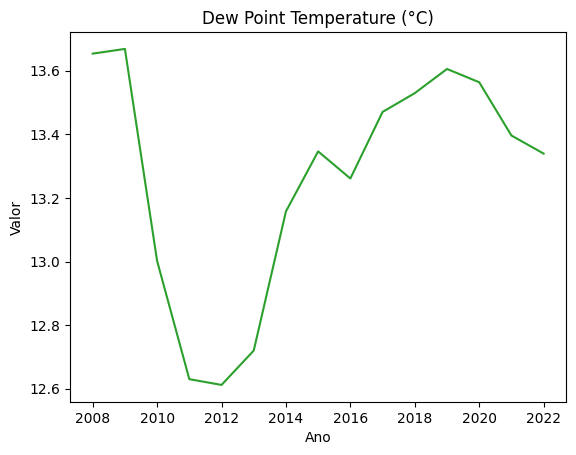

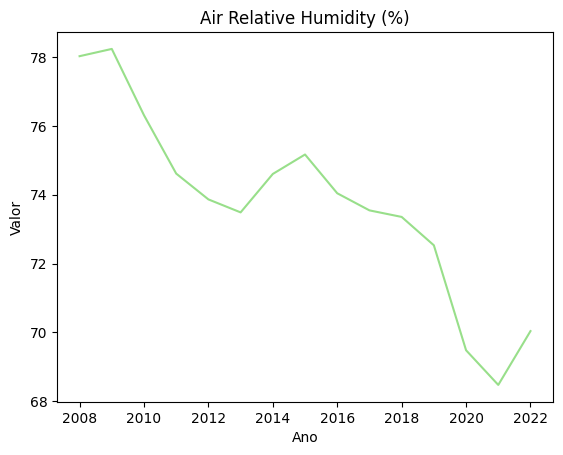

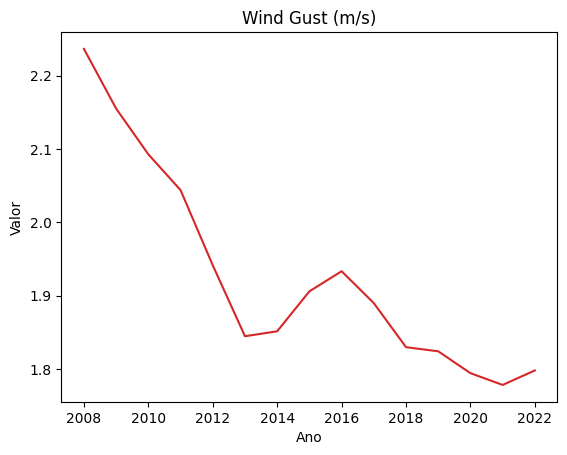

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,17.558665,912.624708,1226.296848,18.012164,13.653739,78.027482,2.236583
2009,16.652522,912.466179,1217.653383,17.954863,13.668549,78.238643,2.155189
2010,17.928528,912.482023,1194.060192,17.703414,13.001948,76.311573,2.092804
2011,18.661309,912.629463,1182.416452,17.710041,12.630186,74.615878,2.043995
2012,19.310061,912.778766,1176.491125,17.874291,12.612094,73.865245,1.941425
2013,19.233593,912.914618,1170.878793,18.105264,12.720105,73.487865,1.844730
2014,20.725057,912.973266,1150.562966,18.275455,13.157699,74.605015,1.851460
2015,22.054778,913.057535,1145.712487,18.177724,13.346348,75.170150,1.905966
2016,22.315526,913.132268,1158.573328,18.115048,13.261122,74.043778,1.933375


In [12]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [13]:
df_2008.to_csv('2008_01_meteo.csv', index=True)